<h1 style=\"text-align: center; font-size: 50px;\">✍️ Handwritten digit classification with keras </h1>
This notebook shows how to do a simple image classification using TensorFlow and MNIST(Modified National Institute of Standards and Technology) database of handwritten digits.


## Notebook Overview
- Imports
- Configurations
- Loading and Preprocessing the Data
- Building Model
- Training the Model
- Logging Model to MLflow
- Fetching the Latest Model Version from MLflow
- Loading the Model and Running Inference


## Imports

In [1]:
# ------------------------ System Utilities ------------------------
import warnings                         
import logging  
import datetime
from PIL import Image
import base64
from io import BytesIO

# ------------------------ Data manipulation libraries ------------------------
import pandas as pd                     
import numpy as np


# ------------------------ Visualization Libraries ------------------------ 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# ------------------------ Deep learning framework ------------------------
from keras.models import load_model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
import torch

# ------------------------ MLflow Integration ------------------------
import mlflow
from mlflow import MlflowClient
from mlflow.models.signature import ModelSignature
from mlflow.types.schema import Schema, ColSpec, TensorSpec, ParamSchema, ParamSpec
import mlflow.keras

2025-05-28 12:34:50.664171: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-28 12:34:50.695030: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748435690.720558    2556 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748435690.727051    2556 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-28 12:34:50.761522: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## Configurations

In [2]:
# Suppress Python warnings
warnings.filterwarnings("ignore")

In [3]:
# Create logger
logger = logging.getLogger("MNIST_logger")
logger.setLevel(logging.INFO)

formatter = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s", 
                              datefmt="%Y-%m-%d %H:%M:%S")  

stream_handler = logging.StreamHandler()
stream_handler.setFormatter(formatter)
logger.addHandler(stream_handler)
logger.propagate = False

In [4]:
# ------------------------- MLflow Experiment Configuration -------------------------
EXPERIMENT_NAME = 'MNIST with TensorFlow'
RUN_NAME = "MNIST_Run"
MODEL_NAME = "MNIST_Model"
MODEL_PATH = "model_keras_mnist.keras"

In [5]:
logger.info('Notebook execution started.')

2025-05-28 12:34:54 - INFO - Notebook execution started.


## Loading and Preprocessing the Data

The MNIST dataset is divided into two categories: training and testing sets. The load_data() function splits into x_train and y_train, coitaining images and their labels, for trainining the model. The other part, x_test and y_test, hold images and their labels for testing the model.

In [6]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [7]:
# One-hot encode
y_cat_test = to_categorical(y_test,10)
y_cat_train = to_categorical(y_train,10)

Reshape to include channel dimension (in this case, 1 channel)

In [8]:
x_train = x_train.reshape(60000, 28, 28, 1).astype('float32')/255

In [9]:
x_test = x_test.reshape(10000,28,28,1).astype('float32')/255

## Building the Model

In [10]:
model = Sequential()

# CONVOLUTIONAL LAYER
model.add(Conv2D(filters=32, kernel_size=(4,4),input_shape=(28, 28, 1), activation='relu',))
# POOLING LAYER
model.add(MaxPool2D(pool_size=(2, 2)))

# FLATTEN IMAGES FROM 28 by 28 to 764 BEFORE FINAL LAYER
model.add(Flatten())

# 128 NEURONS IN DENSE HIDDEN LAYER (YOU CAN CHANGE THIS NUMBER OF NEURONS)
model.add(Dense(128, activation='relu'))

# LAST LAYER IS THE CLASSIFIER, THUS 10 POSSIBLE CLASSES
model.add(Dense(10, activation='softmax'))

model.summary()

2025-05-28 12:34:55.152389: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 25, 25, 32)     │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 591,786 (2.26 MB)

 Trainable params: 591,786 (2.26 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# https://keras.io/metrics/
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy']) # Add in additional metrics https://keras.io/metrics/

In [12]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

## Training the Model

In [13]:
history = model.fit(x_train,y_cat_train,epochs=4,validation_data=(x_test,y_cat_test),callbacks=[early_stop])

Epoch 1/4
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9203 - loss: 0.2672 - val_accuracy: 0.9801 - val_loss: 0.0572
Epoch 2/4
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9855 - loss: 0.0478 - val_accuracy: 0.9868 - val_loss: 0.0396
Epoch 3/4
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9925 - loss: 0.0244 - val_accuracy: 0.9873 - val_loss: 0.0392
Epoch 4/4
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9943 - loss: 0.0183 - val_accuracy: 0.9857 - val_loss: 0.0474


In [14]:
# Evaluate model
test_loss, test_accuracy = model.evaluate(x_test,y_cat_test, verbose = 0)
logger.info(f"test loss: {test_loss}")
logger.info(f"test accuracy: {test_accuracy}")

2025-05-28 12:35:26 - INFO - test loss: 0.04743979126214981
2025-05-28 12:35:26 - INFO - test accuracy: 0.9857000112533569


In [15]:
model.save(MODEL_PATH)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
label:[7], predicted class: 7


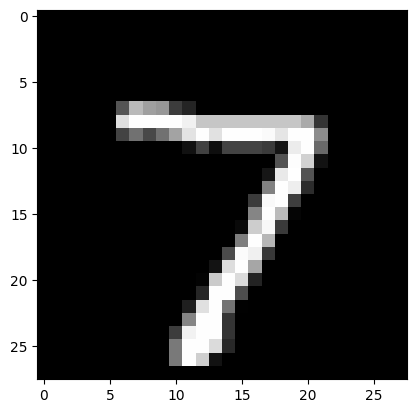

In [16]:
pred = model.predict(x_test[:1])
pred_cls =np.argmax(pred)
print(f'label:{y_test[:1]}, predicted class: {pred_cls}')
image = x_test[:1]
plt.imshow(image.squeeze(), cmap= 'gray')

In [17]:
def base64_to_numpy(base64_string):
    """
        Convert a base64 to a numpy array.
    """
    if "," in base64_string:
        base64_string = base64_string.split(",")[1]
    image_data = base64.b64decode(base64_string)

    image = Image.open(BytesIO(image_data))

    if image.mode != 'L':
        image = image.convert('L')
    image = image.resize((28, 28))

    array = np.array(image) / 255
    
    array = array.reshape(1, 28, 28, 1)

    return array

## Logging Model to MLflow

In [18]:
class MNISTModel(mlflow.pyfunc.PythonModel):
    def load_context(self, context):
        """
        Load keras model.
        """
        try:
            # Load the model
            self.model = load_model(context.artifacts["keras_model"])

        except Exception as e:
            logger.error(f"Error loading context: {str(e)}")
            raise

    def predict(self, context, model_input, params = None):
        """
        Computes the predicted digit, by converting the base64 to a numpy array.
        """
        try:
            if isinstance(model_input, pd.DataFrame):
                image_input = model_input.iloc[0, 0]
            elif isinstance(model_input, list):
                image_input = model_input[0]
            else:
                image_input = str(model_input)
                
            base64_string = base64_to_numpy(image_input)

            predictions = self.model.predict(base64_string)

            predicted_classes = np.argmax(predictions, axis = 1)
            
            return predicted_classes
        
        except Exception as e:
            logger.error(f"Error performing prediction: {str(e)}")
            raise
    
    @classmethod
    def log_model(cls, model_name):
        """
        Logs the model to MLflow with appropriate artifacts and schema.
        """
        try:
            # Define input and output schema
            input_schema = Schema([
                ColSpec("string", name = "digit"),
                ])
            output_schema = Schema([
                ColSpec("long", name = "prediction"),
            ])
            
            # Define model signature
            signature = ModelSignature(inputs=input_schema, outputs=output_schema)
            
            # Log the model in MLflow
            mlflow.pyfunc.log_model(
                model_name,
                python_model=cls(),
                artifacts={
                    "keras_model": MODEL_PATH,           
                },
                signature=signature,

            )
        except Exception as e:
            logger.error(f"Error logging model: {str(e)}")
            raise   

/opt/conda/lib/python3.12/site-packages/mlflow/pyfunc/utils/data_validation.py:168: UserWarning: Add type hints to the `predict` method to enable data validation and automatic signature inference during model logging. Check https://mlflow.org/docs/latest/model/python_model.html#type-hint-usage-in-pythonmodel for more details.
  color_warning(


In [19]:
logger.info(f'Starting the experiment: {EXPERIMENT_NAME}')

# Set the MLflow experiment name
mlflow.set_experiment(experiment_name=EXPERIMENT_NAME)

# Start an MLflow run
with mlflow.start_run(run_name=RUN_NAME) as run:
    # Print the artifact URI for reference
    logging.info(f"Run's Artifact URI: {run.info.artifact_uri}")
    
    mlflow.log_metrics({"test_accuracy": test_accuracy})
    mlflow.log_metrics({"test_lost": test_loss})

    # Log the model to MLflow
    MNISTModel.log_model(model_name=MODEL_NAME)

    # Register the logged model in MLflow Model Registry
    mlflow.register_model(
        model_uri=f"runs:/{run.info.run_id}/{MODEL_NAME}", 
        name=MODEL_NAME
    )

logger.info(f'Registered the model: {MODEL_NAME}')

2025-05-28 12:35:26 - INFO - Starting the experiment: MNIST with TensorFlow


Registered model 'MNIST_Model' already exists. Creating a new version of this model...
Created version '21' of model 'MNIST_Model'.
2025-05-28 12:35:31 - INFO - Registered the model: MNIST_Model


## Fetching the Latest Model Version from MLflow

In [20]:
# Initialize the MLflow client
client = MlflowClient()

# Retrieve the latest version of the model
model_metadata = client.get_latest_versions(MODEL_NAME, stages=["None"])
latest_model_version = model_metadata[0].version  # Extract the latest model version

# Fetch model information, including its signature
model_info = mlflow.models.get_model_info(f"models:/{MODEL_NAME}/{latest_model_version}")

# Print the latest model version and its signature
logger.info(f"Latest Model Version: {latest_model_version}")
logger.info(f"Model Signature: {model_info.signature}")

2025-05-28 12:35:32 - INFO - Latest Model Version: 21
2025-05-28 12:35:32 - INFO - Model Signature: inputs: 
  ['digit': string (required)]
outputs: 
  ['prediction': long (required)]
params: 
  None



## Loading the Model and Running Inference

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


2025-05-28 12:35:32 - INFO - Predicted class: [9]


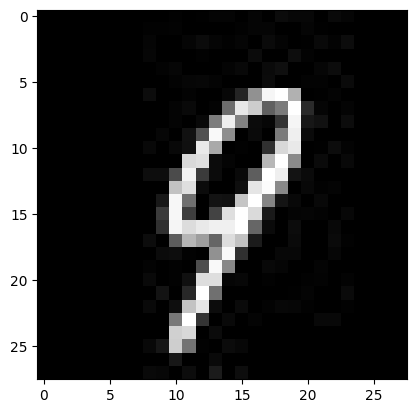

In [21]:
model = mlflow.pyfunc.load_model(model_uri=f"models:/{MODEL_NAME}/{latest_model_version}")

# Base64 example
base = "/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/wAALCAAcABwBAREA/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/9oACAEBAAA/APn+prW0uL66itbSCSe4lbbHFEpZmPoAOtaWt+FtZ8Ox28mqWghS4LCNlmSQblxuU7GO1huGQcHnpWPRXoOiWF/pfhiwh0K2ln8R+JfMWNoh89vaK2w7f7pdg2Wzwq9sk1X+IY03SItJ8JabMLk6QsjX1wpOJLuQr5gHsuxQP/rVw1Fen+EfFmueF/AN3qkup3C2yMbPR7QkBXmbJkk9SsYOcfd3MK8yd3lkaSRizsSzMxyST1JptFXLnVb280+ysJ5y9rYhxbx4AEe9tzdBzk9z7elU6K//2Q=="
numpy_image = base64_to_numpy(base)
# Image of the base64 example
plt.imshow(numpy_image.squeeze(), cmap= 'gray') 

base_input = pd.DataFrame({"digit": [base]})
# Prediction of base64
predictions = model.predict(base_input)

logger.info(f"Predicted class: {predictions}")

In [22]:
logger.info('Notebook execution completed.')

2025-05-28 12:35:33 - INFO - Notebook execution completed.


Built with ❤️ using [**Z by HP AI Studio**](https://zdocs.datascience.hp.com/docs/aistudio/overview).